# Assignment 3: Object detection

In [1]:
# Imports
import os # Module to access Operating System
import cv2 # Module for coputer vision
import keras # Module for deep learning
!pip -q install keras-cv > /dev/null
import keras_cv # Keras module for object detection
os.environ["KERAS_BACKEND"] = "torch"  # @param ["tensorflow", "jax", "torch"]
from keras_cv import bounding_box
from keras_cv import visualization
import tensorflow as tf

Using TensorFlow backend


## Data analysis

In [ ]:
# Download data
if not os.path.exists('data/fish_data_detection'):
    !wget -q --no-check-certificate -O dataset.zip "https://kuleuven-my.sharepoint.com/:u:/g/personal/matthias_deryck_kuleuven_be/EQwO_pgG8vZIk7ZeuO-gUFMB4awxHzEHSps64pORv6-IqA?e=ia37Dl&download=1"
    !unzip -q dataset.zip -d data
    !rm dataset.zip

In [2]:
# Check if GPU is available
print("TensorFlow version: ", tf.__version__) # Version 2.15
print("Built with CUDA: ", tf.test.is_built_with_cuda())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version:  2.13.1
Built with CUDA:  False
Num GPUs Available:  0


In [3]:
# Class mapping
class_ids =  ['ANF', 'BIB', 'HAD', 'GUU', 'WHG', 'SOL', 'PLE', 'GUR', 'MEG', 'WIT']
class_mapping = dict(zip(range(len(class_ids)), class_ids))
 
# Path to images and annotations
path_images = "./data/fish_data_detection/images/"
path_annot = "./data/fish_data_detection/labels/"

In [4]:
# Init lists
image_paths = []
bbox = []
classes = []

# Loop over all samples
for image_path in os.listdir(path_images):

    # Read image
    image = cv2.imread('./data/fish_data_detection/images/' + image_path)
    h, w, c = image.shape

    # Load labels
    boxes = []
    class_ids = []
    with open(path_annot + image_path.replace('.jpg', '.txt'), 'r') as f:
        for line in f:
            tmp = [float(x) for x in line.strip().split()]
            boxes.append([tmp[1]*w, tmp[2]*h, tmp[3]*w, tmp[4]*h])
            class_ids.append(tmp[0])

    # Add to lists
    image_paths.append(path_images + image_path)
    bbox.append(boxes)
    classes.append(class_ids)

KeyboardInterrupt: 

In [ ]:
# Compress the data for easy training
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)
data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

Next, we will performa a train and validation split of the data. 

In [ ]:
# Determine the number of validation samples
SPLIT_RATIO = 0.3
num_val = int(len(os.listdir(path_images)) * SPLIT_RATIO)
 
# Split the dataset into train (70%) and validation sets (30%)
val_data = data.take(num_val)
train_data = data.skip(num_val)

In [ ]:
# Function that converts the data in Keras format
def load_dataset(image_path, classes, bbox):

    # Read the image and decode it to Keras format
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    # Format the labels
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }

    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}
 
# Create a data loader for the training and validation set
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle training set
BATCH_SIZE = 8
train_ds = train_ds.shuffle(BATCH_SIZE * 4)

In [ ]:
# Construct a Ragged dataset
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

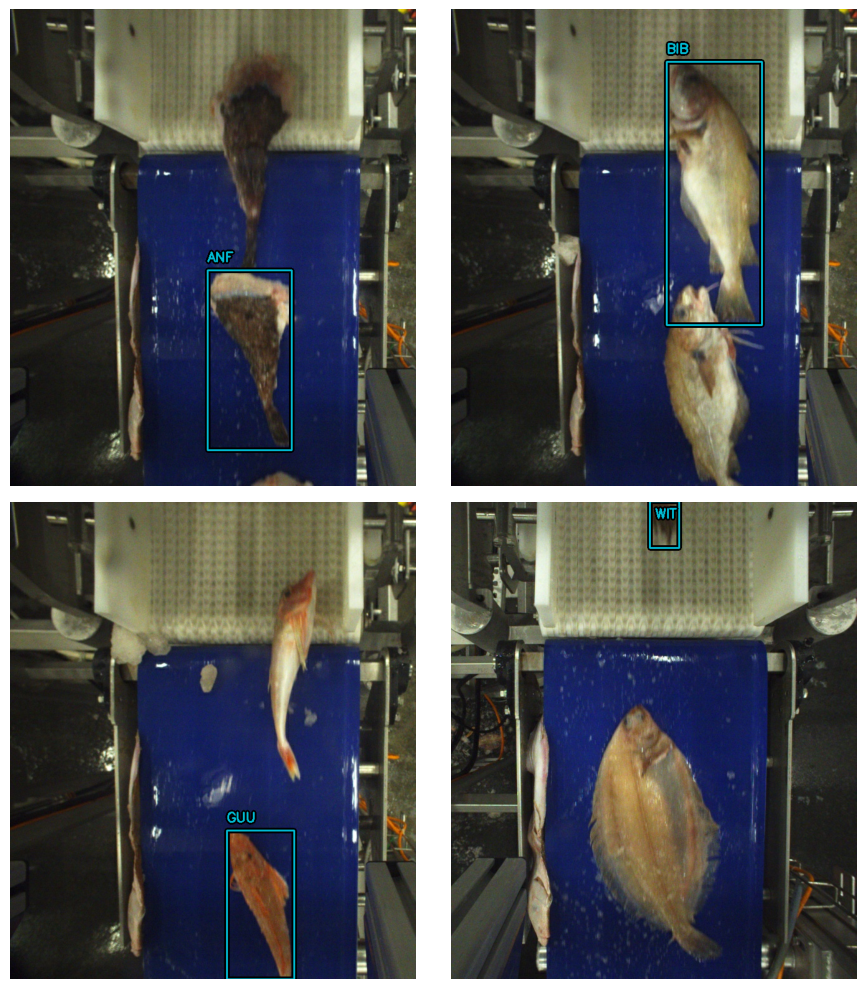

In [ ]:
# Function to visualize dataste samples in a grid
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )
 
# Visualize one batch of the training set
visualize_dataset(train_ds, bounding_box_format="center_xywh", value_range=(0, 255), rows=2, cols=2)

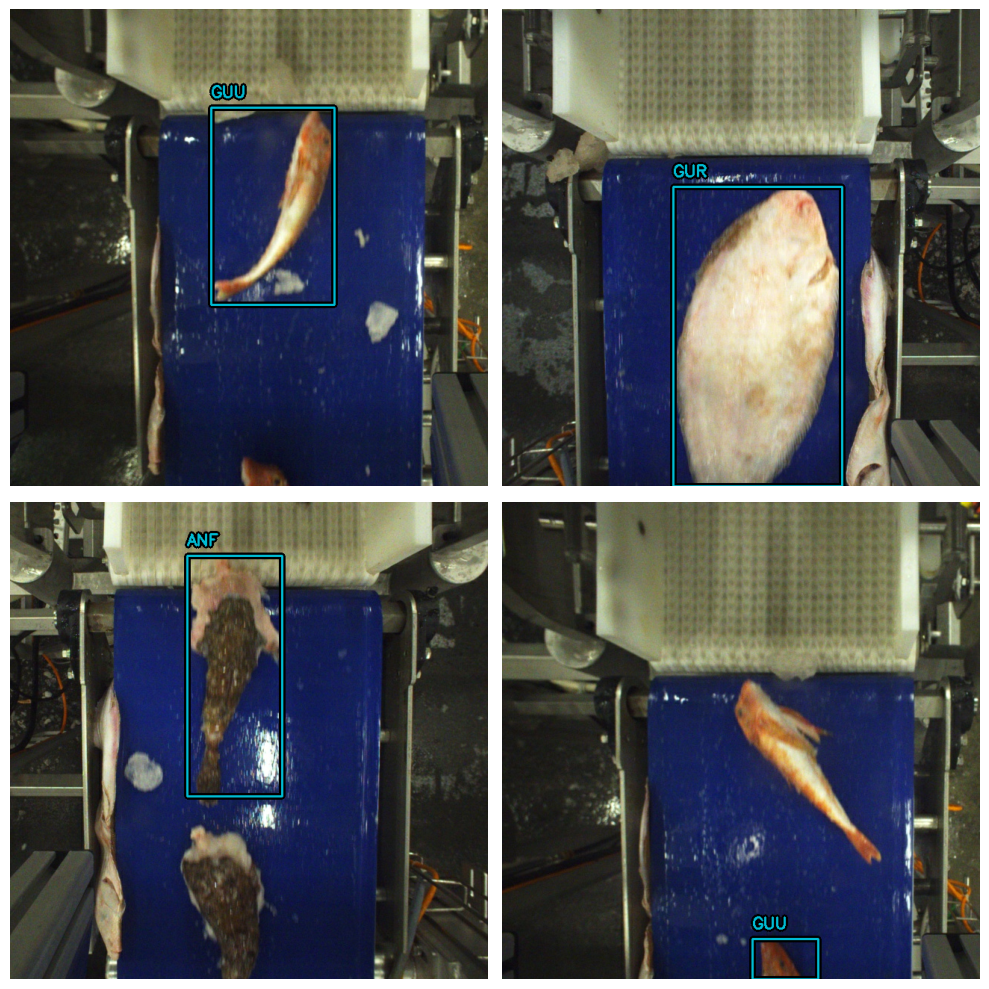

In [ ]:
# Define augmentation layers
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="center_xywh"),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640),
            scale_factor=(1.0, 1.0),
            bounding_box_format="center_xywh",
        ),
    ]
)

# Apply data augmentation to training set
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

# Visualize training set
visualize_dataset(train_ds, bounding_box_format="center_xywh", value_range=(0, 255), rows=2, cols=2)

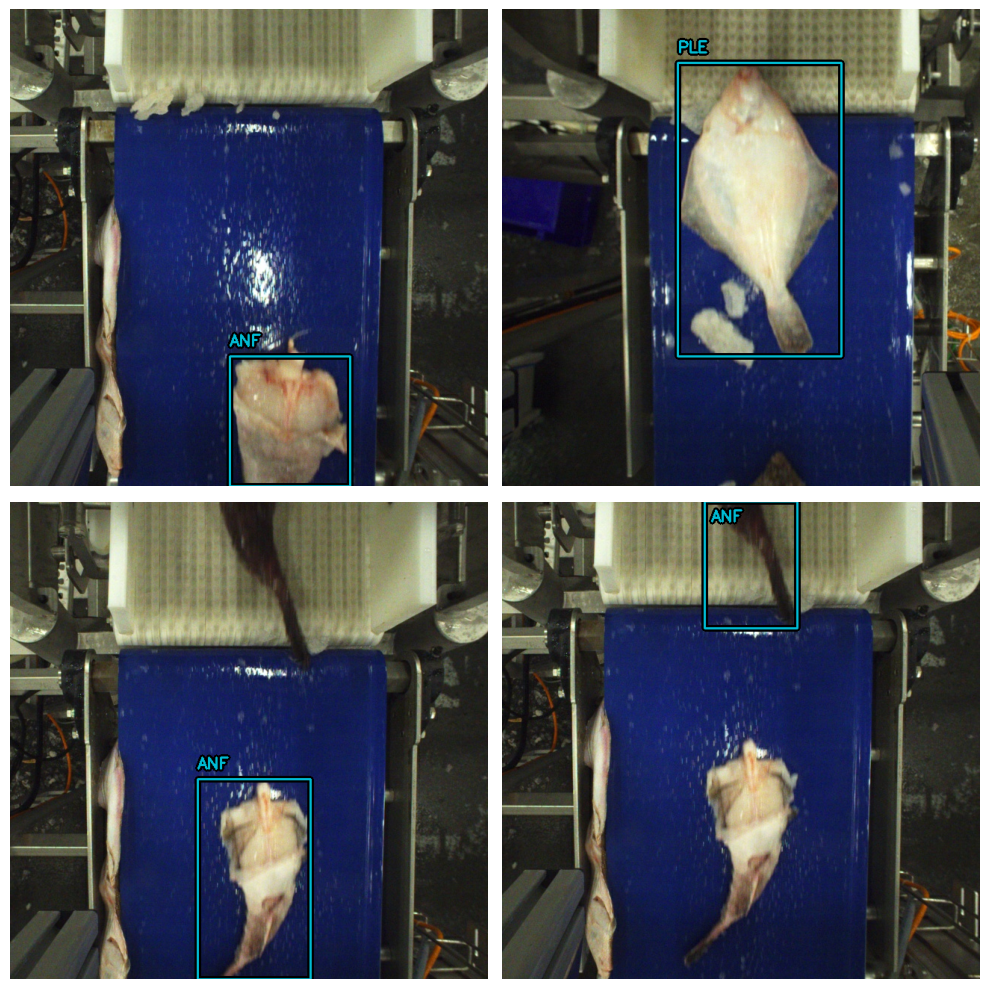

In [ ]:
# Define resizing for validation set
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(1.0, 1.0),
    bounding_box_format="center_xywh",
)

# Apply resizing to validation set
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

# Visualize training set
visualize_dataset(val_ds, bounding_box_format="center_xywh", value_range=(0, 255), rows=2, cols=2)

In [ ]:
def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )
 
train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Model training

In [ ]:
# Create a model using a pretrained backbone
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco"  # We will use yolov8 small backbone with coco weights
)

# Build a yolov8 model using the feature extractor backbone
model = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="center_xywh",
    backbone=backbone,
    fpn_depth=1,
)

In [ ]:
# Set optimizer, loss function, and accuracy metrics
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, global_clipnorm=10.0),
    classification_loss="binary_crossentropy",
    box_loss="ciou",
)

In [ ]:
# Define COCO metrics callback
coco_metrics_callback = keras_cv.callbacks.PyCOCOCallback(
    val_ds, bounding_box_format="center_xywh"
)

In [ ]:
# Train model
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[coco_metrics_callback],
)

Epoch 1/10


69/69 ━━━━━━━━━━━━━━━━━━━━ 66s 872ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.07s).
Accumulating evaluation results...
DONE (t=0.23s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95

KeyboardInterrupt: 

In [ ]:
# Save model
model.save('model.h5')

## Model validation

In [ ]:
# Get batch for inference
visualization_ds = val_ds.unbatch()
visualization_ds = visualization_ds.ragged_batch(16)
visualization_ds = visualization_ds.shuffle(8)

In [ ]:
# Function to visualize detections
def visualize_detections(model, dataset, bounding_box_format):

    # Read one batch
    images, y_true = next(iter(dataset.take(1)))

    # Predict
    y_pred = model.predict(images)

    # Plot ground thruth and predictions
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


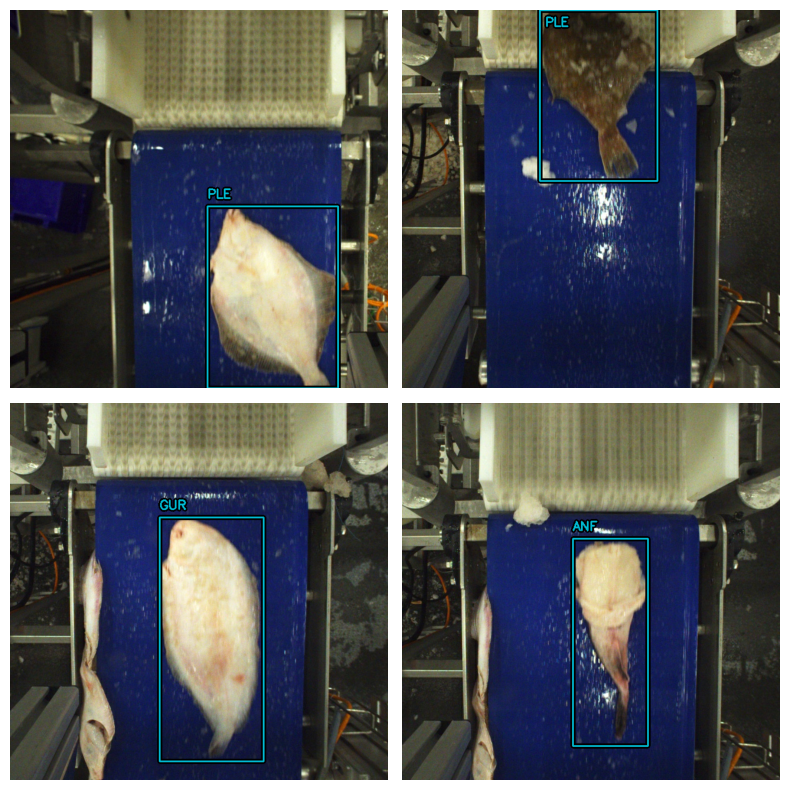

In [ ]:
# Define Nonmax supressor
model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="center_xywh",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.75,
)

# Visualize detections
visualize_detections(model, dataset=visualization_ds, bounding_box_format="center_xywh")